# 0. Import libraries and some useful functions

In [1]:
# Helper libraries
import tweepy
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
from pandas import read_csv
from datetime import datetime
import math
import os
import re
import nltk
import string
import pickle
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', -1)

# !pip install git+https://github.com/erikavaris/tokenizer.git
!pip install wordcloud
!pip install vaderSentiment
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
from imblearn.over_sampling import SMOTE

from sklearn.feature_extraction import text 
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.naive_bayes import MultinomialNB

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, SpatialDropout1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 133kB 2.8MB/s 
2.2.0-rc4


Using TensorFlow backend.


In [0]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(true_labels, predictions, 
                          classes =[], 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    This code is adapted from 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm = confusion_matrix(true_labels, predictions)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    
    num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
    if len(classes) == 0:
        num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
        classes = range(num_classes)
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [0]:
def plot_piechart(Y, Y_pred):
  n_pos = len([y for y in Y if y == 1])
  n_neg = len([y for y in Y if y == 0])
  n_neut = len([y for y in Y if y == 2])
  n = len(Y)

  labels = 'Positive', 'Negative', 'Neutral'
  counts = [n_pos, n_neg, n_neut]

  n_pos_pred = len([y for y in Y_pred if y == 1])
  n_neg_pred = len([y for y in Y_pred if y == 0])
  n_neut_pred = len([y for y in Y_pred if y == 2])
  n_pred = len(Y_pred)
  counts_pred = [n_pos_pred, n_neg_pred, n_neut_pred]

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
  ax1.pie(counts, labels=labels, autopct='%1.1f%%')
  ax2.pie(counts_pred, labels=labels, autopct='%1.1f%%')
  ax1.set_title('Sentiment in test set')
  ax2.set_title('Sentiment prediction in test set')
  plt.show()

In [0]:
def to_df_results(precision, recall, f1_score):
  
  precision_neg = 0
  precision_pos = 0
  precision_neut = 0
  for p in precision:
    precision_neg += p[0]
    precision_pos += p[1]
    precision_neut += p[2]

  precision_neg /= len(precision)
  precision_pos /= len(precision)
  precision_neut /= len(precision)
  precision = [precision_neg, precision_pos, precision_neut]

  recall_neg = 0
  recall_pos = 0
  recall_neut = 0
  for p in recall:
    recall_neg += p[0]
    recall_pos += p[1]
    recall_neut += p[2]

  recall_neg /= len(recall)
  recall_pos /= len(recall)
  recall_neut /= len(recall)
  recall = [recall_neg, recall_pos, recall_neut]

  f1_neg = 0
  f1_pos = 0
  f1_neut = 0
  for p in f1_score:
    f1_neg += p[0]
    f1_pos += p[1]
    f1_neut += p[2]

  f1_neg /= len(f1_score)
  f1_pos /= len(f1_score)
  f1_neut /= len(f1_score)
  f1 = [f1_neg, f1_pos, f1_neut]

  df_result = pd.DataFrame(data={'precision':precision, 'recall':recall, 'f1_score':f1})

  return df_result

# 1. Connect to Twitter API

In [0]:
# Consumer keys and access tokens, used for OAuth
consumer_key = "zEwLdTrV9Hb4dEnziymwfpkIb"         
consumer_secret = "d4MLVwYGJLQuRfUaV1D2cmNwBbIT3py7h1HYeONTuidHJNbrF8"   
access_token = "1245812619409309697-3rTcJMrkcUeNtqWbDobuqPvWRC9ArH"            
access_token_secret = "RIE75UhVnUxQQVYVMwJsziEHukMPlNKqHX9Wc16FVzFlx"  

auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 
auth.set_access_token(access_token, access_token_secret)

# Calling the api
api = tweepy.API(auth) 

# 2. Extract tweets into a dataframe

In [0]:
def get_related_tweets(query, until_date=None, since_id=None, max_id=None, language="en", n=10):
    
    # search query without retweets
    tweets = tweepy.Cursor(api.search,
                       q=query + " -filter:retweets",
                       lang=language,
                       tweet_mode="extended",
                       until = until_date,
                       since_id = since_id,
                       max_id = max_id
                      ).items(n)

    tweet_id = []
    tweet_handle = []
    tweet_text = []

    for tweet in tweets:
        tweet_id.append(tweet.id)
        tweet_handle.append(tweet.user.screen_name)
        tweet_text.append(tweet.full_text)

    df = pd.DataFrame({'id':tweet_id,
                       'handle':tweet_handle,
                       'tweet': tweet_text})
    
    df.to_csv(f"{query}.csv")
    
    return df

In [0]:
query = "donald trump"
lang = "en"

df_trump = get_related_tweets(query, n=1500)

In [0]:
df_trump = read_csv('donald_trump_disinfectant.csv')

In [0]:
df_trump = df_trump.drop(columns=['Unnamed: 0'])
df_trump.head(n=10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,id,handle,tweet
0,1254162422711099405,qerese,"Say it loud, say it clear: Donald Trump needs to resign over his handling of the coronavirus https://t.co/7w6nB0tGQz via @BostonGlobe"
1,1254162421796663297,GlantonholdenJ,Donald Trump is a child. https://t.co/4KosSyiyCV
2,1254162417262657536,billkempin,"My ""economic impact payment"" arrived in the mail today. Donald Trump's name is on the $1,200 check, but it's not his signature. So I wasted $90 taking a MasterClass on forgery."
3,1254162414477533185,RogueAmerican_1,@realDonaldTrump We have 330 million Americans Donald Trump. Get to work.
4,1254162409335541766,ceebright,"@DonaldJTrumpJr @nytimes @JoeBiden At least 17 women have accused Donald Trump of varying inappropriate behavior, including allegations of sexual harassment or sexual assault: \n1. Jessica Leeds\n2. Kristin Anderson\n3. Jill Harth\n4. Cathy Heller\n5. Temple Taggart McDowell\n6. Karena Virginia\n7. Bridget Sullivan..."
5,1254162400703664137,jeremyspangler,Today at Donald Trump's interview \n#coronavirus \n#Covid_19 \n#COVID \n#NEWSで妄想 \n#NEWSに恋して \n#NEWSで妄想ピンク \n#NEWS\n#NewsToday https://t.co/pVk5TJOkmR
6,1254162393610899456,LindaMottet,Seriously dark and empty man named Donald Trump. https://t.co/a6Rg1Jw16A
7,1254162392251957248,unfinis06265716,"@leashless @steel_weaver @davidsteven Who would you personally have emergency-replace Donald Trump?\n\n(It's fine to pick more than one person to hypothetically replace him -- a duo or trio might be better than a single replacement-president right now, anyway)."
8,1254162388930174978,amylynnerock,@DonaldJTrumpJr @nytimes @JoeBiden All the President's Women: Donald Trump and the Making of a Predator https://t.co/VyBOIvlIli
9,1254162387554492416,geetee1207,DONALD TRUMP HAS A SHARE IN A NEW YORK PROPERTY DEVELOPMENT THAT BORROWED TENS OF MILLIONS OF DOLLARS FROM CHINA \nTrump attack on Biden highlights president's own past dealings with China https://t.co/TIsTYNLP7x


# 3. Data exploration

Date of retrieval : 25/04/2020

Major event : Yesterday, Trump publicly declared that injecting yourself disinfectant might help protect yourself and kill the COVID virus.

### Length distribution

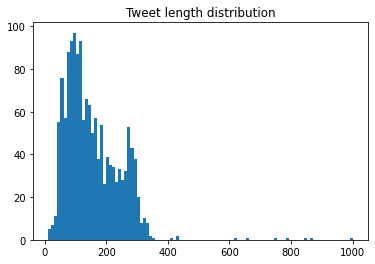

In [0]:
length_tweets = []

for index, tweet in df_trump.iterrows():
    length_tweets.append(len(tweet['tweet']))

fig, ax = plt.subplots()
ax.set_title('Tweet length distribution')
plot = ax.hist(length_tweets, bins=100)

### Clean text

In [0]:
def preprocess_data(dataset):

  punct = string.punctuation

  punct =  re.sub(' ', '', punct) # keep spaces
  # punct =  re.sub('#', '', punct)  # keep hashtags
  punct =  re.sub('\'', '', punct) # keep single quotes (in order to retain I'm, isn't, etc.)

  for index, row in dataset.iterrows():

    # lower case
    row['text'] = row['text'].lower()

    # remove "rt"
    row['text'] = row['text'].replace('rt','')

    # remove urls
    row['text'] = re.sub('https?://\S+', '', row['text'])
    row['text'] = re.sub('https?://.*...', '', row['text'])

    # remove numbers
    row['text'] = re.sub('\d+', '', row['text'])

    # remove mentions
    row['text'] = re.sub('@\S+', ' ', row['text'])

    # remove punctuation
    row['text'] = "".join([char for char in row['text'] if char not in punct])

    # remove additional whitespaces
    row['text'] = re.sub('\s+', ' ', row['text'])
    row['text'] = row['text'].strip()

    dataset.at[index, 'text'] = row['text']

  return dataset

In [0]:
df_trump = df_trump.rename(columns={'tweet': 'text'})
df_trump = preprocess_data(df_trump)

In [0]:
df_trump.head(n=5)

,id,handle,text
0,1254162422711099405,qerese,say it loud say it clear donald trump needs to resign over his handling of the coronavirus via
1,1254162421796663297,GlantonholdenJ,donald trump is a child
2,1254162417262657536,billkempin,my economic impact payment arrived in the mail today donald trump's name is on the check but it's not his signature so i wasted taking a masterclass on forgery
3,1254162414477533185,RogueAmerican_1,we have million americans donald trump get to work
4,1254162409335541766,ceebright,at least women have accused donald trump of varying inappropriate behavior including allegations of sexual harassment or sexual assault jessica leeds kristin anderson jill hah cathy heller temple tagga mcdowell karena virginia bridget sullivan


### WordCloud


Wordcloud:


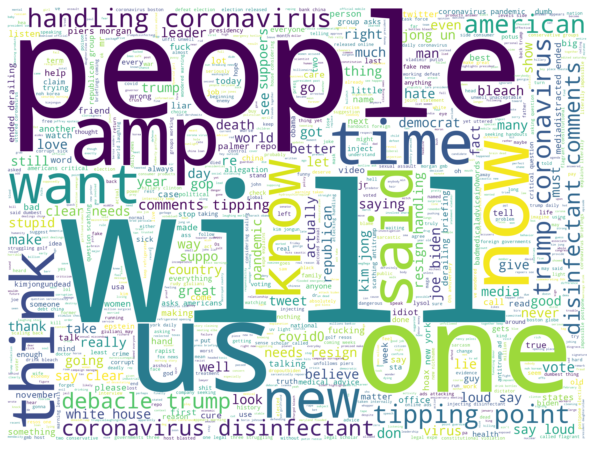

In [0]:
text = ''
for index, tweet in df_trump.iterrows():
    text += tweet['text'] + ' '

# limit word count
wordcount = 1000

# stop words
stopwords = set(STOPWORDS)
stopwords_list = ["br", "donald", "trump", "president", "realdonaldtrump", "us", "america", "united", "state", "via"]
stopwords.update(stopwords_list)

# setup word cloud
wc = WordCloud(scale=3, background_color="white", max_words=wordcount, stopwords=stopwords, width=800, height=600)

# generate word cloud
wc.generate(text)

# show
print('\nWordcloud:')
plt.figure(figsize=(12,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Most frequent words (barplot representation)

In [0]:
tweets = []
for index, tweet in df_trump.iterrows():
    tweets.append(tweet['text'])

my_additional_stop_words = ['donald', 'trump', 'president']
sw_list = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

tokenizer = CountVectorizer(strip_accents='ascii', ngram_range=(1,2), stop_words=sw_list, min_df=2, max_features=5000)
tokenizer.fit(tweets)
bag_of_words = tokenizer.transform(tweets)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in tokenizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

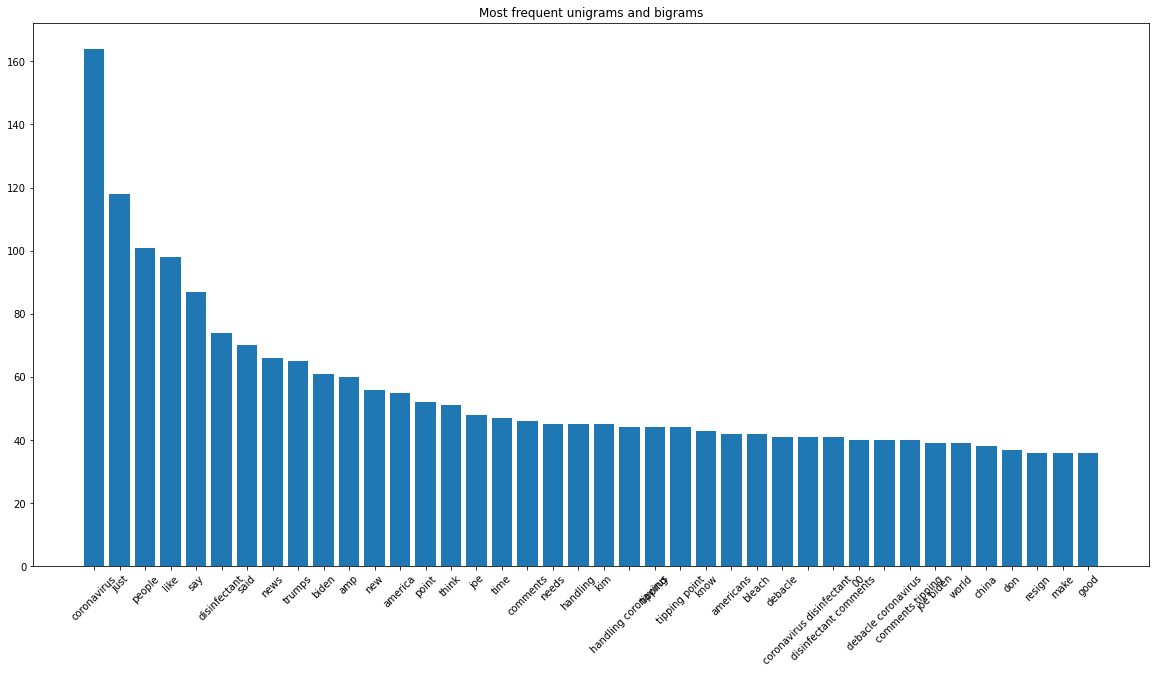

In [0]:
top_words = words_freq[:40]
ngrams = []
counts = []
for ngram in top_words:
  ngrams.append(ngram[0])
  counts.append(ngram[1])

fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Most frequent unigrams and bigrams')
plt.xticks(rotation=45)
plot = ax.bar(ngrams, height=counts)

# 4. Sentiment analysis : Training on a labeled Twitter dataset 

The training set that will be used is the first GOP Debate Twitter Sentiment dataset. It is composed of 13 871 tweets on the first 2016 GOP Presidential Debate that had taken place in Ohio.

"*We looked through tens of thousands of tweets about the early August GOP debate in Ohio and asked contributors to do both sentiment analysis and data categorization. Contributors were asked if the tweet was relevant, which candidate was mentioned, what subject was mentioned, and then what the sentiment was for a given tweet. We've removed the non-relevant messages from the uploaded dataset.*"

The main advantage of this dataset is that it is composed of the same type of tweets than those that we need to classify. This training dataset should help with tackling the problem of detection of sarcasm in a political context.

### Import training dataset

In [0]:
gop_dataset = read_csv("Sentiment.csv", header=0, index_col=0)

In [0]:
train_dataset = gop_dataset[['text', 'sentiment']]

for index, row in train_dataset.iterrows():

  if row['sentiment'] == 'Negative':
    row['sentiment'] = 0

  elif row['sentiment'] == 'Positive':
    row['sentiment'] = 1
    
  else :
    row['sentiment'] = 2

In [0]:
train_dataset.head(n=10)

,text,sentiment
id,,
1,RT @NancyLeeGrahn: How did everyone feel about the Climate Change question last night? Exactly. #GOPDebate,2
2,RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF…,1
3,RT @TJMShow: No mention of Tamir Rice and the #GOPDebate was held in Cleveland? Wow.,2
4,RT @RobGeorge: That Carly Fiorina is trending -- hours after HER debate -- above any of the men in just-completed #GOPdebate says she's on …,1
5,RT @DanScavino: #GOPDebate w/ @realDonaldTrump delivered the highest ratings in the history of presidential debates. #Trump2016 http://t.co…,1
6,"RT @GregAbbott_TX: @TedCruz: ""On my first day I will rescind every illegal executive action taken by Barack Obama."" #GOPDebate @FoxNews",1
7,RT @warriorwoman91: I liked her and was happy when I heard she was going to be the moderator. Not anymore. #GOPDebate @megynkelly https://…,0
8,Going on #MSNBC Live with @ThomasARoberts around 2 PM ET. #GOPDebate,2
9,"Deer in the headlights RT @lizzwinstead: Ben Carson, may be the only brain surgeon who has performed a lobotomy on himself. #GOPDebate",0


### Explore dataset


In [0]:
n_pos = len(train_dataset[train_dataset['sentiment']==1])
n_neg = len(train_dataset[train_dataset['sentiment']==0])
n_neut = len(train_dataset[train_dataset['sentiment']==2])
n = len(train_dataset)

print("Number of positive tweets : %d (%.2f%%)" % (n_pos, n_pos/n*100))
print("Number of negative tweets : %d (%.2f%%)" % (n_neg, n_neg/n*100))
print("Number of neutral tweets : %d (%.2f%%)" % (n_neut, n_neut/n*100))

Number of positive tweets : 2236 (16.12%)
Number of negative tweets : 8493 (61.23%)
Number of neutral tweets : 3142 (22.65%)


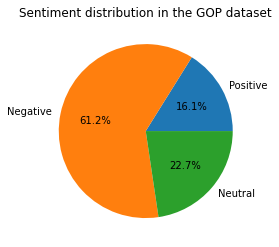

In [0]:
labels = 'Positive', 'Negative', 'Neutral'
counts = [n_pos, n_neg, n_neut]

fig, ax = plt.subplots()
ax.pie(counts, labels=labels, autopct='%1.1f%%')
ax.set_title('Sentiment distribution in the GOP dataset')
plt.show()

Unfortunately our training dataset is imbalanced, with only 16% of positive tweets and more than 60% of negative tweets. This imbalancy will be a problem while traning models as it might lead to confusing results and the accuracy paradox. If an accuracy of 60% is reached, this result cannot really be trusted as it will only reflect the underlying class distribution.

Solutions to an imbalanced dataset :
- Collect more data : oversampling with SMOTE ?
- Use other metrics than accuracy : precision, recall, F1-score
- Use penalized models

In [0]:
train_dataset_cleaned = preprocess_data(train_dataset)

In [0]:
text_pos = []
text_neg = []
text_neut = []

for index, tweet in train_dataset_cleaned.iterrows():
  if tweet['sentiment'] == 1:
    text_pos.append(tweet['text'])
  elif tweet['sentiment'] == 0:
    text_neg.append(tweet['text'])
  else :
    text_neut.append(tweet['text'])

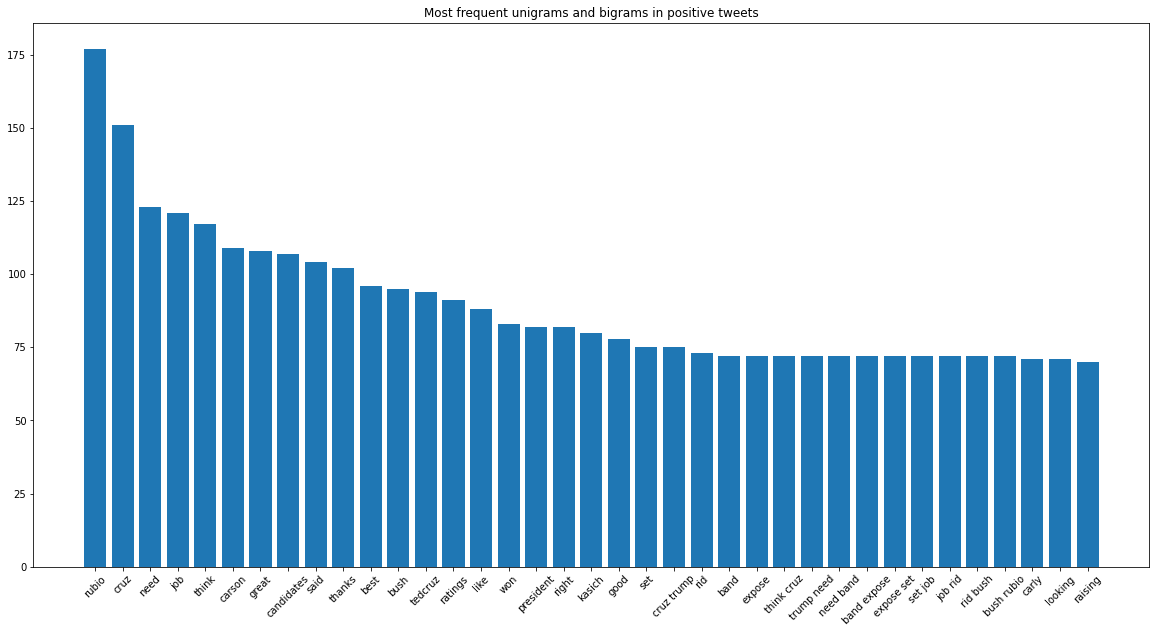

In [0]:
my_additional_stop_words = ['gopdebate', 'debate', 'gop', 'fox', 'news', 'amp']
sw_list = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

tokenizer = CountVectorizer(strip_accents='ascii', ngram_range=(1,2), stop_words=sw_list, min_df=2, max_features=5000)
tokenizer.fit(text_pos)
bag_of_words = tokenizer.transform(text_pos)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in tokenizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

# most frequent words (remove words "donald" and "trump")
top_words = words_freq[3:40]
ngrams = []
counts = []
for ngram in top_words:
  ngrams.append(ngram[0])
  counts.append(ngram[1])

fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Most frequent unigrams and bigrams in positive tweets')
plt.xticks(rotation=45)
plot = ax.bar(ngrams, height=counts)

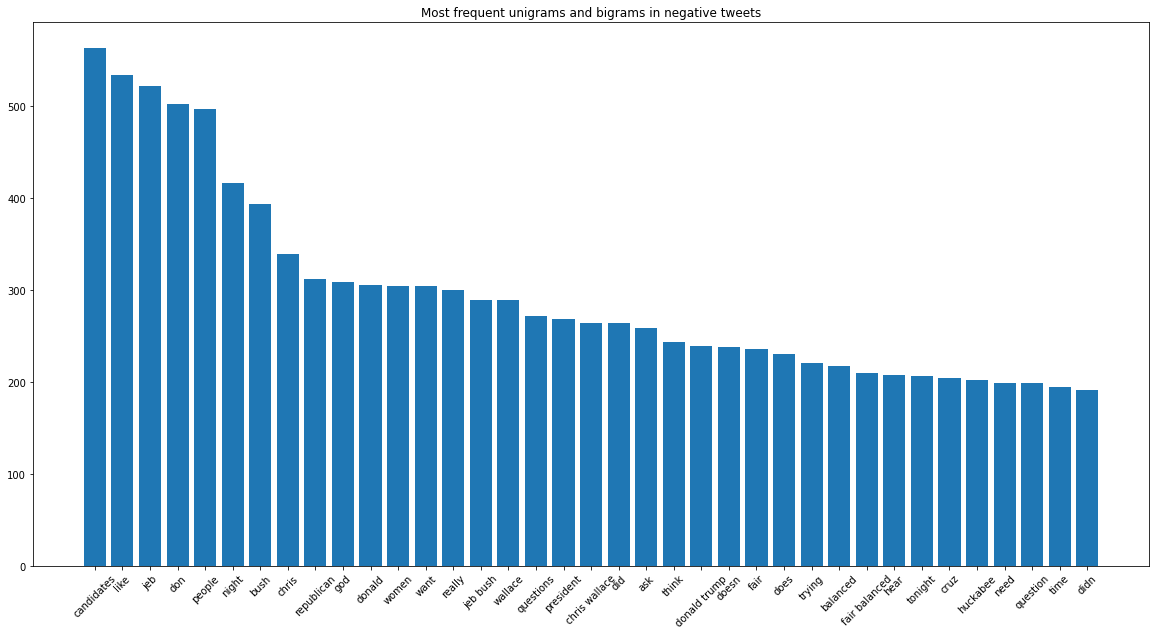

In [0]:
tokenizer = CountVectorizer(strip_accents='ascii', ngram_range=(1,2), stop_words=sw_list, min_df=2, max_features=5000)
tokenizer.fit(text_neg)
bag_of_words = tokenizer.transform(text_neg)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in tokenizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

# most frequent words (remove words "donald" and "trump")
top_words = words_freq[3:40]
ngrams = []
counts = []
for ngram in top_words:
  ngrams.append(ngram[0])
  counts.append(ngram[1])

fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Most frequent unigrams and bigrams in negative tweets')
plt.xticks(rotation=45)
plot = ax.bar(ngrams, height=counts)

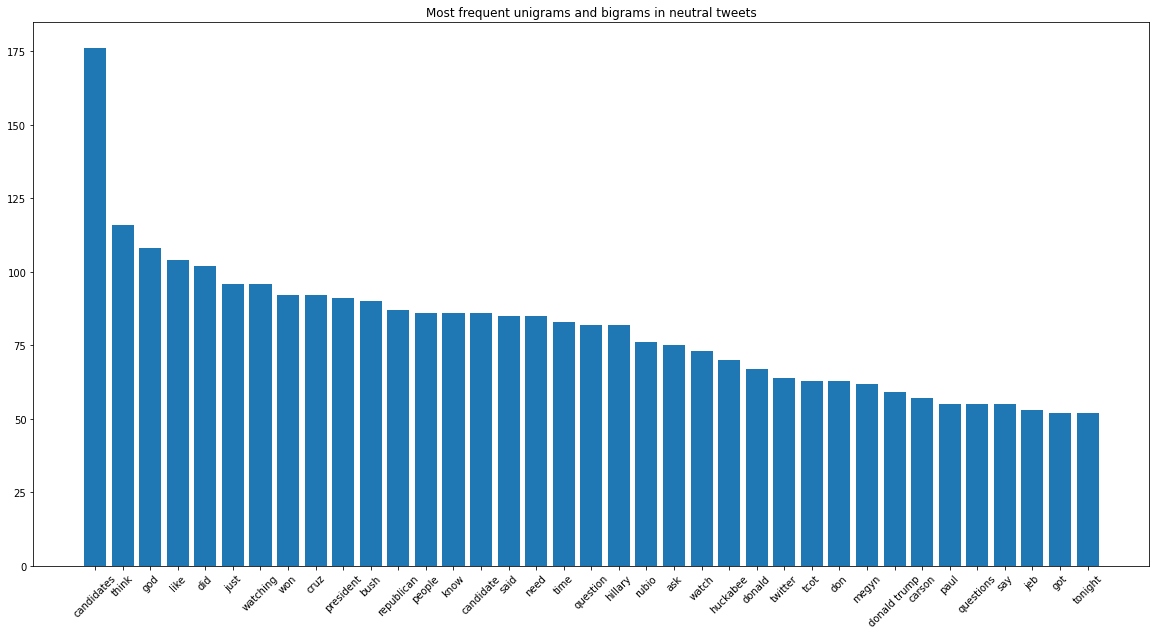

In [0]:
tokenizer = CountVectorizer(strip_accents='ascii', ngram_range=(1,2), stop_words=sw_list, min_df=2, max_features=5000)
tokenizer.fit(text_neut)
bag_of_words = tokenizer.transform(text_neut)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in tokenizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

# most frequent words (remove words "donald" and "trump")
top_words = words_freq[3:40]
ngrams = []
counts = []
for ngram in top_words:
  ngrams.append(ngram[0])
  counts.append(ngram[1])

fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Most frequent unigrams and bigrams in neutral tweets')
plt.xticks(rotation=45)
plot = ax.bar(ngrams, height=counts)

### Sentiment analysis library : TextBlob analyzer

TextBlob is a library that can be used for various text processing tasks. It especially includes a sentiment analysis module.

In [0]:
tweet_polarity = []

for index, row in train_dataset_cleaned.iterrows():
    pol = TextBlob(row['text']).sentiment.polarity
    if pol > 0:
      sentiment = 1
    elif pol < 0:
      sentiment = 0
    else : 
      sentiment = 2

    tweet_polarity.append(sentiment)
    
train_dataset_cleaned['polarity_blob'] = tweet_polarity
train_dataset_cleaned.head(n=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,text,sentiment,polarity_blob
id,,,
1,how did everyone feel about the climate change question last night exactly gopdebate,2,1
2,didn't catch the full gopdebate last night here are some of scott's best lines in seconds walker,1,1
3,no mention of tamir rice and the gopdebate was held in cleveland wow,2,1
4,that carly fiorina is trending hours after her debate above any of the men in justcompleted gopdebate says she's on …,1,2
5,gopdebate w delivered the highest ratings in the history of presidential debates trump,1,2


Confusion matrix, without normalization


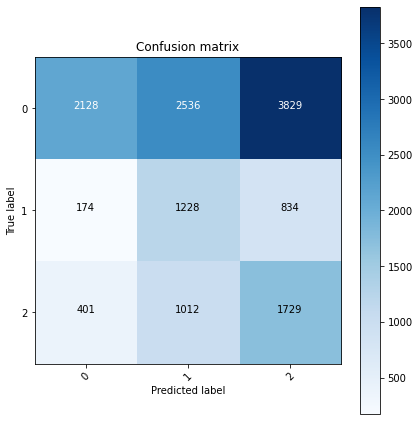

In [0]:
sentiment = []
pred_blob = []

for index, row in train_dataset_cleaned.iterrows():
  sentiment.append(row['sentiment'])
  pred_blob.append(row['polarity_blob'])

plot_confusion_matrix(sentiment, pred_blob)

In [0]:
print(classification_report(sentiment, pred_blob))

              precision    recall  f1-score   support

           0       0.79      0.25      0.38      8493
           1       0.26      0.55      0.35      2236
           2       0.27      0.55      0.36      3142

    accuracy                           0.37     13871
   macro avg       0.44      0.45      0.36     13871
weighted avg       0.58      0.37      0.37     13871



The results obtained with TextBlob are not satisfying :
- A lot of predicted neutral tweets compared to its true number
- Negative tweets are really badly classified, as shows the recall. Most of the true negative tweets are classified as either positive or neutral.

TextBlob's sentiment analysis module was trained on a movie review dataset. However, movie reviews are very different from tweets. Tweets, and especially politically related tweets, can contain a lot of sarcasm and other Twitter specifics. In particular, in our dataset here, tweets with a very high positive polarity (e.g. >0.5) look like they often are sarcastic. 

It is necessary to find a dataset of tweets with sentiment analysis done already. We will then be able to train a model on it, and eventually use it to classify our coronavirus tweets.

### Sentiment analysis library : VADER analyzer

Unlike TextBlob's sentiment analyzer, VADER is specifically fitted to analyze social media content, and especially tweets.

*VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. VADER uses a combination of A sentiment lexicon is a list of lexical features (e.g., words) which are generally labelled according to their semantic orientation as either positive or negative.*

In [0]:
analyser = SentimentIntensityAnalyzer()

tweet_polarity = []

for index, row in train_dataset_cleaned.iterrows():
    pol = analyser.polarity_scores(row['text'])['compound']
    if pol >= 0.05:
      sentiment = 1
    elif pol <= -0.05:
      sentiment = 0
    else : 
      sentiment = 2

    tweet_polarity.append(sentiment)
    
train_dataset_cleaned['polarity_vader'] = tweet_polarity
train_dataset_cleaned.head(n=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,text,sentiment,polarity_blob,polarity_vader
id,,,,
1,how did everyone feel about the climate change question last night exactly gopdebate,2,1,2
2,didn't catch the full gopdebate last night here are some of scott's best lines in seconds walker,1,1,1
3,no mention of tamir rice and the gopdebate was held in cleveland wow,2,1,1
4,that carly fiorina is trending hours after her debate above any of the men in justcompleted gopdebate says she's on …,1,2,2
5,gopdebate w delivered the highest ratings in the history of presidential debates trump,1,2,2


Confusion matrix, without normalization


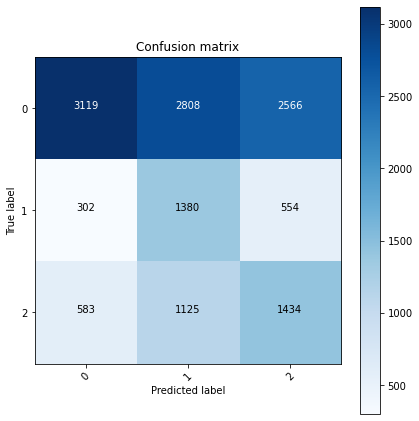

In [0]:
sentiment = []
pred_vader = []

for index, row in train_dataset_cleaned.iterrows():
  sentiment.append(row['sentiment'])
  pred_vader.append(row['polarity_vader'])

plot_confusion_matrix(sentiment, pred_vader)

In [0]:
print(classification_report(sentiment, pred_vader))

              precision    recall  f1-score   support

           0       0.78      0.37      0.50      8493
           1       0.26      0.62      0.37      2236
           2       0.31      0.46      0.37      3142

    accuracy                           0.43     13871
   macro avg       0.45      0.48      0.41     13871
weighted avg       0.59      0.43      0.45     13871



Though VADER analyzer performs much better than Textblob's, it is still not very satisfying. However we can note that :
*   Negative tweets are much better classified
*   Positive and negative classes in general have a better recall
*   Only performance on neutral class is worst



### Crossvalidation function

After having tried two pre-trained libraries and gotten poor performances, we will explore some ML classification algorithms and train them on our GOP dataset. To this end, cross-validation will be used to compare the different models' performances.

In [0]:
def cv_train(X, Y, n_splits, tknzr, classifier, oversampling):
  precision = []
  recall = []
  f1_score = []
  counts = [0, 0, 0]
  counts_pred = [0, 0, 0]
  accuracy = 0

  kfold = KFold(n_splits, True, 1)

  for train, test in kfold.split(X):
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    Y_train = Y[train]

    tknzr.fit(X_train)
    X_train = tknzr.transform(X_train)

    if oversampling :
      n_neg = len(Y_train==0)
      oversample = SMOTE(sampling_strategy={1: math.ceil(n_neg*0.4), 2 : math.ceil(n_neg*0.5)})
      X_train, Y_train = oversample.fit_resample(X_train, Y_train)

    classifier.fit(X_train, Y_train)

    X_test = tknzr.transform(X_test)
    yPred = classifier.predict(X_test)

    prec, rec, f1, _ = precision_recall_fscore_support(Y[test], yPred)
    precision.append(prec)
    recall.append(rec)
    f1_score.append(f1)
    accuracy += accuracy_score(Y[test], yPred)

    n_pos = len([y for y in Y[test] if y == 1])
    n_neg = len([y for y in Y[test] if y == 0])
    n_neut = len([y for y in Y[test] if y == 2])
    counts = [sum(x) for x in zip(counts, [n_pos, n_neg, n_neut])]

    n_pos_pred = len([y for y in yPred if y == 1])
    n_neg_pred = len([y for y in yPred if y == 0])
    n_neut_pred = len([y for y in yPred if y == 2])
    counts_pred = [sum(x) for x in zip(counts_pred, [n_pos_pred, n_neg_pred, n_neut_pred])]

  accuracy = float(accuracy)/n_splits
  print("Accuracy = %.2f " % accuracy)
  print('-'*50)
  print(to_df_results(precision, recall, f1_score))
  print('-'*50)
  counts = [c/n_splits for c in counts]
  counts_pred = [c/n_splits for c in counts_pred]

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
  ax1.pie(counts, labels=labels, autopct='%1.1f%%')
  ax2.pie(counts_pred, labels=labels, autopct='%1.1f%%')
  ax1.set_title('Sentiment in test set')
  ax2.set_title('Sentiment prediction in test set')
  plt.show()

In [0]:
X = train_dataset_cleaned['text']
Y = train_dataset_cleaned['sentiment']
Y = np.asarray(Y, dtype=np.float64)
Y = Y.astype('int')

### Naive Bayes

#### Original dataset (not oversampled)

Two feature extraction techniques will be tested : CountVectorizer and TfIdf Vectorizer.

Accuracy = 0.63 
--------------------------------------------------
   precision    recall  f1_score
0  0.781038   0.699760  0.737998
1  0.503230   0.517349  0.509034
2  0.400638   0.504641  0.446201
--------------------------------------------------


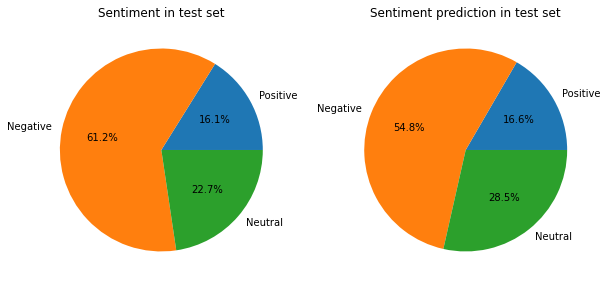

In [0]:
tknzr = CountVectorizer(strip_accents='ascii', ngram_range=(1,2), stop_words='english', min_df=2, max_features=5000)
classifier = MultinomialNB()
cv_train(X, Y, 10, tknzr, classifier, False)

Accuracy = 0.68 
--------------------------------------------------
   precision    recall  f1_score
0  0.700601   0.911235  0.791984
1  0.671687   0.339623  0.449333
2  0.517034   0.277518  0.360578
--------------------------------------------------


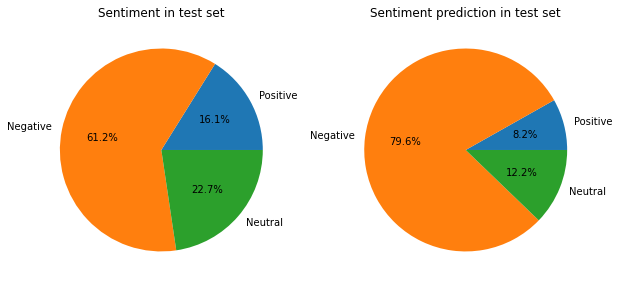

In [0]:
tknzr = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=2, max_features=5000, strip_accents='ascii')
classifier = MultinomialNB()

cv_train(X, Y, 10, tknzr, classifier, False)

#### Oversampled dataset 

As the dataset is quite imbalanced with most of the samples being classified as negative, it might be useful to use an oversampling technique so as to rebalance classes. The dataset is already too small to use an undersampling technique (delete negative samples). We will use the SMOTE technique, which stands for Synthetic Minority Oversampling Technique. This method basically creates new data based on existing samples. 

We choose respective proportions of 0.4 and 0.5*number of negative tweets for positive and neutral tweets in the final distribution. The number of positive and neutral tweets will be increased but still inferior to the proportion of negative tweets. Keeping a majority of negative tweets is important.

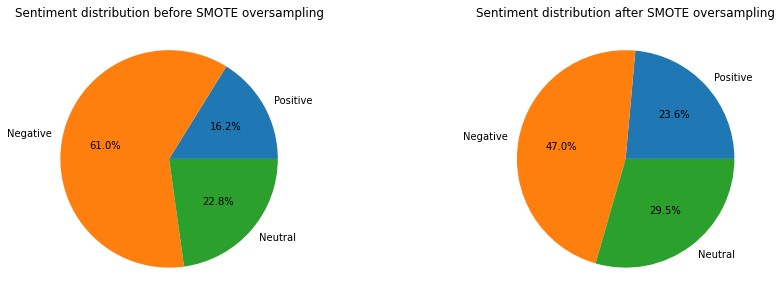

In [0]:
# Example of SMOTE usage
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

tokenizer = CountVectorizer(strip_accents='ascii', ngram_range=(1,2), stop_words='english', min_df=2, max_features=5000)
tokenizer.fit(X_train)
X_train = tokenizer.transform(X_train)

oversample = SMOTE(sampling_strategy={1: math.ceil(n_neg*0.4), 2 : math.ceil(n_neg*0.5)})
X_oversampled, y_oversampled = oversample.fit_resample(X_train, y_train)

labels = 'Positive', 'Negative', 'Neutral'
counts_before = [np.sum(y_train == 1), np.sum(y_train == 0), np.sum(y_train == 2)]
counts_after = [np.sum(y_oversampled == 1), np.sum(y_oversampled == 0), np.sum(y_oversampled == 2)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.pie(counts_before, labels=labels, autopct='%1.1f%%')
ax1.set_title('Sentiment distribution before SMOTE oversampling')
ax2.pie(counts_after, labels=labels, autopct='%1.1f%%')
ax2.set_title('Sentiment distribution after SMOTE oversampling')
plt.show()

Accuracy = 0.62 
--------------------------------------------------
   precision    recall  f1_score
0  0.801588   0.672212  0.730960
1  0.506521   0.504015  0.504492
2  0.396300   0.570286  0.466841
--------------------------------------------------


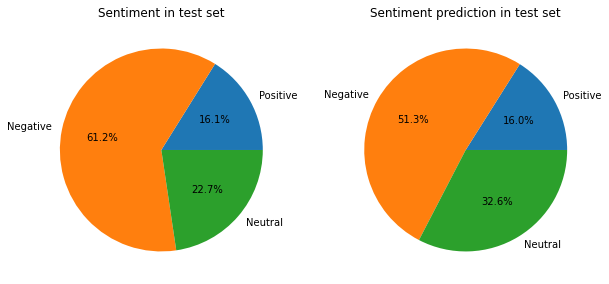

In [0]:
tknzr = CountVectorizer(strip_accents='ascii', ngram_range=(1,2), stop_words='english', min_df=2, max_features=5000)
classifier = MultinomialNB()
cv_train(X, Y, 10, tknzr, classifier, oversampling=True)

Accuracy = 0.63 
--------------------------------------------------
   precision    recall  f1_score
0  0.796981   0.692187  0.740710
1  0.506654   0.531544  0.517878
2  0.407758   0.538031  0.463492
--------------------------------------------------


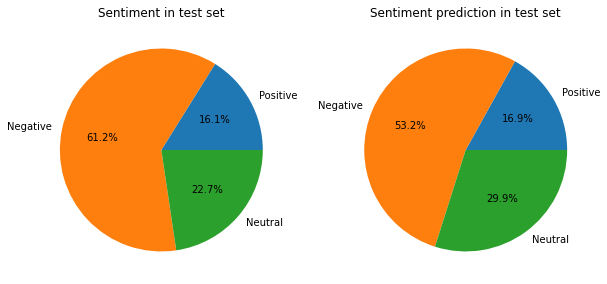

In [0]:
tknzr = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=2, max_features=5000, strip_accents='ascii')
classifier = MultinomialNB()
cv_train(X, Y, 10, tknzr, classifier, True)

Working with oversampled data does improves performance if we look at the f1 score. It seems like it's mostly helping with increasing the recall on the classes in minority. However it is also important to note that precision decreases to the price of an increased recall. 

### Logistic Regression

#### Original dataset (not oversampled)

Accuracy = 0.67 
--------------------------------------------------
   precision    recall  f1_score
0  0.738375   0.839851  0.785757
1  0.586328   0.472329  0.522080
2  0.478292   0.366184  0.414511
--------------------------------------------------


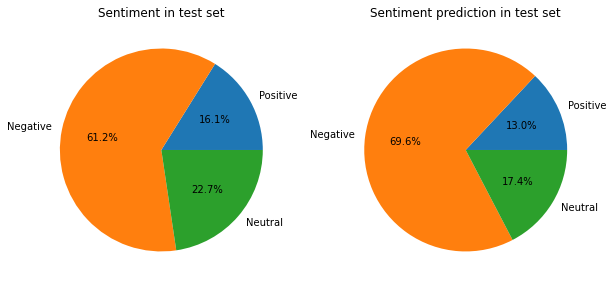

In [0]:
classifier = LogisticRegression(max_iter=1000, multi_class = "multinomial")
tknzr = CountVectorizer(strip_accents='ascii', ngram_range=(1,2), stop_words='english', min_df=2, max_features=5000)
cv_train(X, Y, 10, tknzr, classifier, False)

Accuracy = 0.69 
--------------------------------------------------
   precision    recall  f1_score
0  0.716516   0.907945  0.800820
1  0.652326   0.405102  0.498581
2  0.553350   0.302272  0.390350
--------------------------------------------------


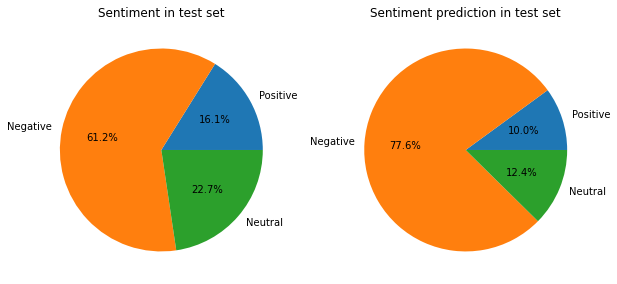

In [0]:
tknzr = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=2, max_features=5000, strip_accents='ascii')
classifier = LogisticRegression(max_iter=1000, multi_class = "multinomial")
cv_train(X, Y, 10, tknzr, classifier, False)

#### Oversampled dataset

Accuracy = 0.64 
--------------------------------------------------
   precision    recall  f1_score
0  0.777454   0.733145  0.754547
1  0.482178   0.533242  0.505656
2  0.446332   0.481218  0.462901
--------------------------------------------------


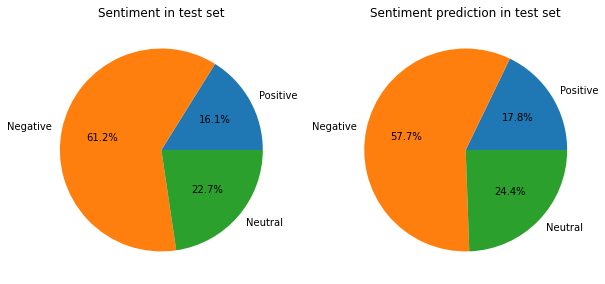

In [0]:
classifier = LogisticRegression(max_iter=1000, multi_class = "multinomial")
tknzr = CountVectorizer(strip_accents='ascii', ngram_range=(1,2), stop_words='english', min_df=2, max_features=5000)
cv_train(X, Y, 10, tknzr, classifier, True)

Accuracy = 0.66 
--------------------------------------------------
   precision    recall  f1_score
0  0.790971   0.749488  0.769555
1  0.524942   0.561109  0.541279
2  0.447880   0.488896  0.467216
--------------------------------------------------


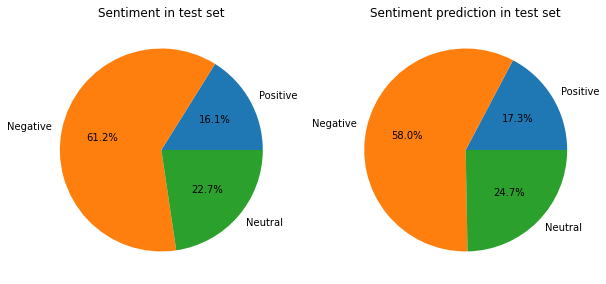

In [0]:
tknzr = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=2, max_features=5000, strip_accents='ascii')
classifier = LogisticRegression(max_iter=1000, multi_class = "multinomial")
cv_train(X, Y, 10, tknzr, classifier, True)

#### With stemming preprocessing

We also would like to try to stem the tweets and see if it can help with classification.

In [0]:
def textblob_tokenizer(str_input):
  blob = TextBlob(str_input.lower())
  tokens = blob.words
  words = [token.stem() for token in tokens]
  return words

Accuracy = 0.65 
--------------------------------------------------
   precision    recall  f1_score
0  0.780988   0.745572  0.762720
1  0.493847   0.543231  0.516557
2  0.459534   0.482888  0.470803
--------------------------------------------------


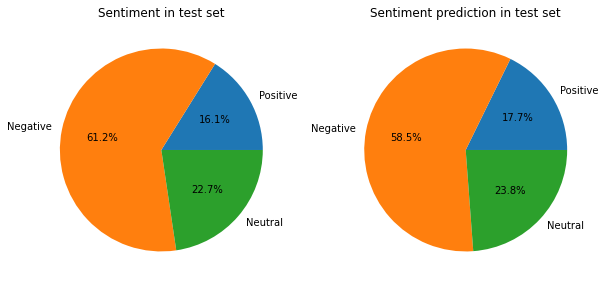

In [0]:
tknzr = CountVectorizer(strip_accents='ascii', ngram_range=(1,2), stop_words='english', max_features=5000, min_df=2, tokenizer=textblob_tokenizer)
classifier = LogisticRegression(max_iter=1000, multi_class = "multinomial")
cv_train(X, Y, 10, tknzr, classifier, True)

Unfortunately, stemming does not improve performance.

Our best model so far is the logistic regression classifier, with TfIdf vectorizer and oversampled data.

### Deep Learning : RNN

Let's also explore deep learning and RNN in particular, which are well adapted to NLP problems. The small size of our dataset can however be a problem to the training of such a complex model. 

##### Prepare data

In [0]:
X = train_dataset_cleaned['text']
Y = train_dataset_cleaned['sentiment']
Y = np.asarray(Y, dtype=np.float64)
Y = Y.astype('int')

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(11096,) (11096,)
(2775,) (2775,)


In [0]:
n_neg = len(Y_train[Y_train==0])
print('Number of negative tweets in training set : ', n_neg)

Number of negative tweets in training set :  6771


In [0]:
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X_train.values)
X_train = tokenizer.texts_to_sequences(X_train.values)

X_train = pad_sequences(X_train)
Y_train = pd.get_dummies(Y_train).values

In [0]:
# Use the tokenizer fit on training data to transform test data
X_test = tokenizer.texts_to_sequences(X_test.values)
X_test = pad_sequences(X_test, maxlen=X_train.shape[1])

Y_test = pd.get_dummies(Y_test).values

In [0]:
oversample = SMOTE(sampling_strategy={1: math.ceil(n_neg*0.4), 2 : math.ceil(n_neg*0.5)})
X_train, Y_train = oversample.fit_resample(X_train, Y_train)

In [0]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

##### Define functions

In [0]:
def print_acc_loss(model) :

  [train_loss, train_accuracy] = model.evaluate(X_train, Y_train, verbose=0)
  print("Training set Accuracy:{:7.4f}".format(train_accuracy))
  print("Training set Loss:{:7.4f}\n".format(train_loss))

  [val_loss, val_accuracy] = model.evaluate(X_test, Y_test, verbose=0)
  print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
  print("Validation set Loss:{:7.4f}\n".format(val_loss))

def plot_history(history):
  plt.figure(figsize = (12,4))
  
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.legend()

In [0]:
def LSTM_model(embed_dim = 128, lstm_out = [128,128,128]):

  model = Sequential()

  model.add(Embedding(max_features, embed_dim, input_length = X_train.shape[1]))
  model.add(SpatialDropout1D(0.2))

  model.add(LSTM(lstm_out[0], dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
  model.add(LSTM(lstm_out[1], dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
  model.add(LSTM(lstm_out[2], dropout=0.4, recurrent_dropout=0.4))

  model.add(Dense(128,activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(64,activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(3, activation='softmax'))

  model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

  print(model.summary())

  return model 

In [0]:
def fit_model(model, bs=64, n_epochs=5):

  LSTM_history = model.fit(X_train, Y_train, 
                         epochs = n_epochs, 
                         batch_size = bs, 
                         verbose = 1,
                         validation_data=(X_test, Y_test),
                         shuffle=True)
  
  return LSTM_history

##### Train model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 28, 128)           640000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 28, 128)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 28, 64)            49408     
_________________________________________________________________
lstm_7 (LSTM)                (None, 28, 64)            33024     
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

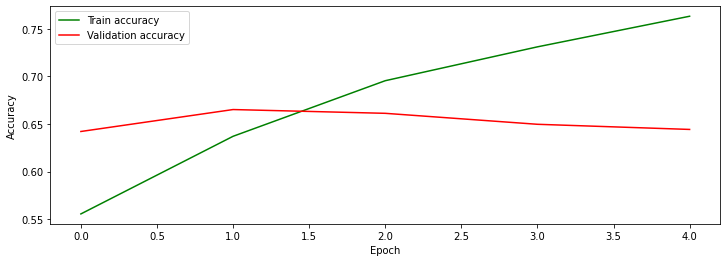

In [0]:
model = LSTM_model(lstm_out=[64,64,64], embed_dim=128)
LSTM_history = fit_model(model, n_epochs=5, bs=64)

print_acc_loss(model)
plot_history(LSTM_history)

##### Evaluate on validation data

In [0]:
Y_test_reverse = [np.argmax(y) for y in Y_test]
Y_pred = np.argmax(model.predict(X_test), axis=-1)

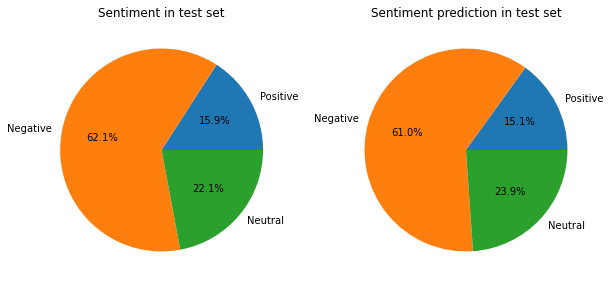

In [0]:
plot_piechart(Y_test_reverse, Y_pred)

Confusion matrix, without normalization


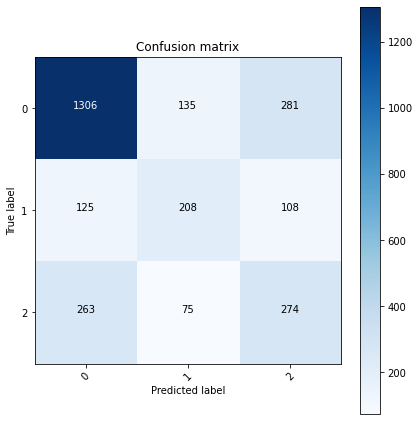

In [0]:
plot_confusion_matrix(Y_test_reverse, Y_pred)

In [0]:
print(classification_report(Y_test_reverse, Y_pred))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1722
           1       0.50      0.47      0.48       441
           2       0.41      0.45      0.43       612

    accuracy                           0.64      2775
   macro avg       0.56      0.56      0.56      2775
weighted avg       0.65      0.64      0.65      2775



Certainly due to the lack of data samples, the performance reached with an LSTM model is not as good as a logistic regression model.

# 5. Predict on Trump dataset

From the previous analysis, logistic regression turned out to be the best classifier. Thus, we will train a new model on the whole dataset. That will be the model we will use for sentiment analysis in our API.

In [0]:
tknzr = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=2, max_features=5000, strip_accents='ascii')
tknzr.fit(train_dataset_cleaned['text'])
X = tknzr.transform(train_dataset_cleaned['text'])

# save tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tknzr, handle, protocol=pickle.HIGHEST_PROTOCOL)

n_neg = len(train_dataset_cleaned[train_dataset_cleaned['sentiment'] == 0])

oversample = SMOTE(sampling_strategy={1: math.ceil(n_neg*0.4), 2 : math.ceil(n_neg*0.5)})
X_oversampled, y_oversampled = oversample.fit_resample(X, train_dataset_cleaned['sentiment'])

In [0]:
Y = np.asarray(y_oversampled)
Y = Y.astype('int')

lr_clf = LogisticRegression(max_iter=1000, multi_class = "multinomial")
lr_clf.fit(X_oversampled, Y)

# save the model to disk
filename = 'model_log_reg.sav'
pickle.dump(lr_clf, open(filename, 'wb'))

In [11]:
# import saved tweet dataset
df_trump = read_csv('donald_trump_disinfectant.csv')
df_trump = df_trump.drop(columns = ['Unnamed: 0', 'handle'])
df_trump = df_trump.rename(columns={'tweet': 'text'})
df_trump.head()

,id,text
0,1254162422711099405,"Say it loud, say it clear: Donald Trump needs to resign over his handling of the coronavirus https://t.co/7w6nB0tGQz via @BostonGlobe"
1,1254162421796663297,Donald Trump is a child. https://t.co/4KosSyiyCV
2,1254162417262657536,"My ""economic impact payment"" arrived in the mail today. Donald Trump's name is on the $1,200 check, but it's not his signature. So I wasted $90 taking a MasterClass on forgery."
3,1254162414477533185,@realDonaldTrump We have 330 million Americans Donald Trump. Get to work.
4,1254162409335541766,"@DonaldJTrumpJr @nytimes @JoeBiden At least 17 women have accused Donald Trump of varying inappropriate behavior, including allegations of sexual harassment or sexual assault: \n1. Jessica Leeds\n2. Kristin Anderson\n3. Jill Harth\n4. Cathy Heller\n5. Temple Taggart McDowell\n6. Karena Virginia\n7. Bridget Sullivan..."


In [0]:
df_trump_clean = df_trump.copy()
df_trump_clean = preprocess_data(df_trump_clean)

In [0]:
# load previously saved tokenizer
tokenizer = pickle.load(open('tokenizer.pickle', 'rb'))
X_trump = tokenizer.transform(df_trump_clean['text'])

In [0]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
Y_trump = loaded_model.predict(X_trump)

In [15]:
df_trump['sentiment'] = Y_trump
df_trump.head(n=3)

,id,text,sentiment
0,1254162422711099405,"Say it loud, say it clear: Donald Trump needs to resign over his handling of the coronavirus https://t.co/7w6nB0tGQz via @BostonGlobe",0
1,1254162421796663297,Donald Trump is a child. https://t.co/4KosSyiyCV,0
2,1254162417262657536,"My ""economic impact payment"" arrived in the mail today. Donald Trump's name is on the $1,200 check, but it's not his signature. So I wasted $90 taking a MasterClass on forgery.",2


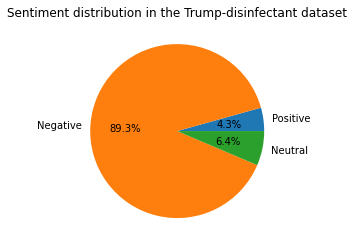

In [0]:
n_pos = len(df_trump[df_trump['sentiment']==1])
n_neg = len(df_trump[df_trump['sentiment']==0])
n_neut = len(df_trump[df_trump['sentiment']==2])

labels = 'Positive', 'Negative', 'Neutral'
counts = [n_pos, n_neg, n_neut]

fig, ax = plt.subplots()
ax.pie(counts, labels=labels, autopct='%1.1f%%')
ax.set_title('Sentiment distribution in the Trump-disinfectant dataset')
plt.show()

In [0]:
df_trump[df_trump['sentiment']==1].head(n=20)

,id,text,sentiment
19,1254162330880966656,@NateGearyWGR His hands aren't THAT small...they are somewhere between Dr.Fauchi size hands and Donald Trump size hands.,1
44,1254162102270525440,"News flash: North Korea's Leader Kim is brain dead, but still making more sense than Donald Trump",1
50,1254162078841163777,"Download the official Donald Trump for President mobile app to get involved and share it with your friends! Together, let's Keep America Great! https://t.co/VFbFzYFFqT",1
104,1254161617761325056,"@thehill She is not good at her job, but in her defense her job is impossible thanks to Donald Trump.",1
108,1254161594415710214,"Download the official Donald Trump for President mobile app to get involved and share it with your friends! Together, let's Keep America Great! https://t.co/6IGmzkcr6B",1
127,1254161420205334529,@SonnyVermont @artsyboy1985 Just in case I wasn't clear yes I agree Donald Trump is the real enemy.,1
136,1254161333752221696,"Download the official Donald Trump for President mobile app to get involved and share it with your friends! Together, let's Keep America Great! https://t.co/X0ReIC2gMo",1
166,1254161105192136704,"How to get free vbucks: Step 50. Shake hands with Donald Trump (alternatively, become the president).",1
244,1254160362233974785,@DaNiggaTrump Thanks for the info Donald Trump 💯🙏,1
264,1254160161410777089,"@johncardillo The cherished leader, respected by his nation, and best friend of Dennis Rodman passed away this week. He was the only National Leader that force Donald Trump to meet him on his terms and property. For the first time ever, American Leadership capitulated to the Leader of NK.",1
